## Курсовая работа

#### Загрузка данных

##### Описание датасета

- __Id__ - идентификационный номер квартиры
- __DistrictId__ - идентификационный номер района
- __Rooms__ - количество комнат
- __Square__ - площадь
- __LifeSquare__ - жилая площадь
- __KitchenSquare__ - площадь кухни
- __Floor__ - этаж
- __HouseFloor__ - количество этажей в доме
- __HouseYear__ - год постройки дома
- __Ecology_N__ - экологические показатели местности
- __Social_N__ - социальные показатели местности
- __Healthcare_N__ - показатели местности, связанные с охраной здоровья
- __Shops_N__ - показатели, связанные с наличием магазинов, торговых центров
- __Price__ - цена квартиры


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
from sklearn import preprocessing
import datetime
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor


warnings.filterwarnings('ignore')

In [3]:
TRAIN_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'
SAMPLE_PATH = '/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv'

In [4]:
ds = pd.read_csv(TRAIN_PATH)
ds.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [6]:
ds.shape

(10000, 20)

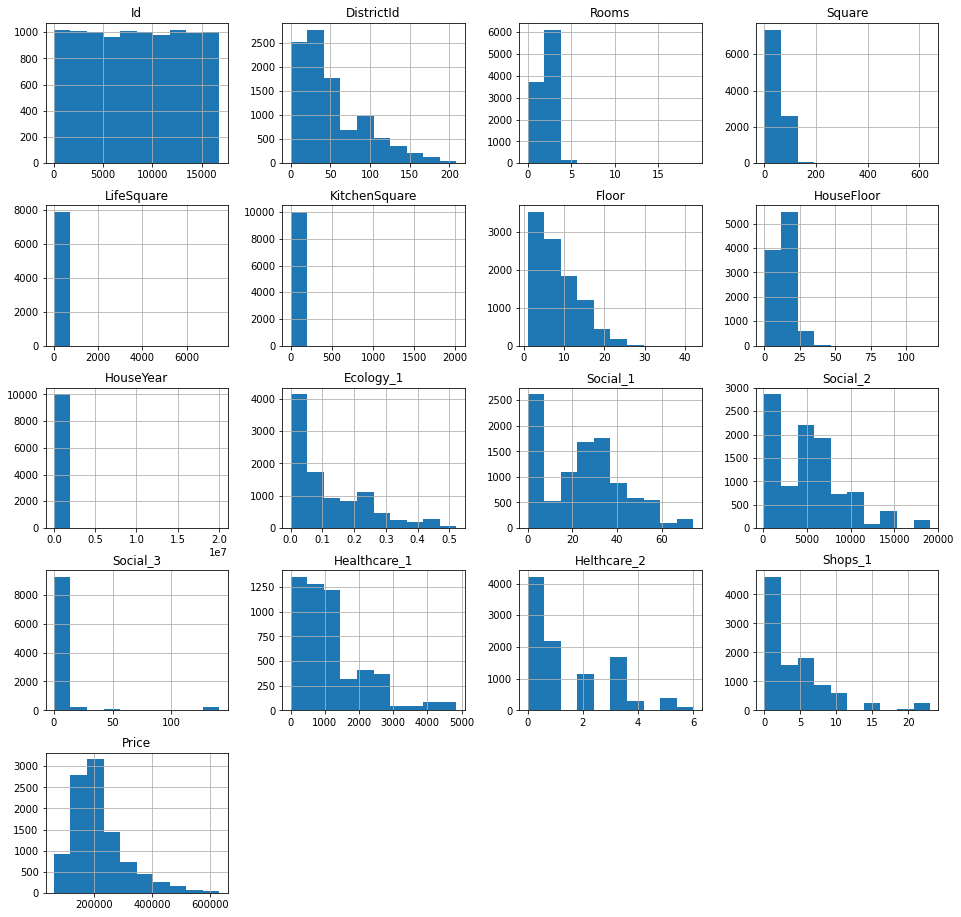

In [7]:
ds.hist(figsize=(16,16))
plt.show()

<AxesSubplot:>

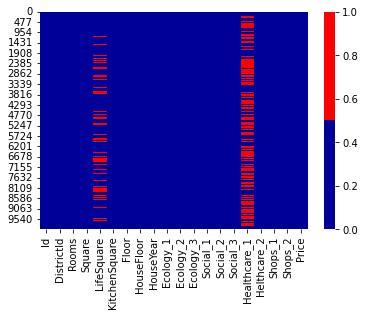

In [8]:
ds.drop('Id', axis=1)
colours = ['#000099', '#ff0000']
sns.heatmap(ds.isnull(), cmap=sns.color_palette(colours))

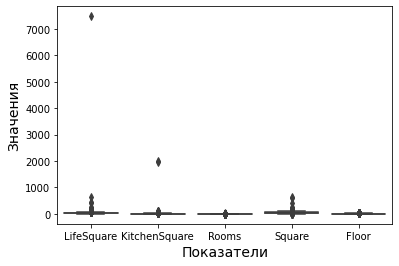

In [9]:
boxplot = sns.boxplot(x="variable", y="value", data=pd.melt(ds[['LifeSquare','KitchenSquare','Rooms','Square','Floor']]))
boxplot.set_xlabel("Показатели", fontsize=14)
boxplot.set_ylabel("Значения", fontsize=14);

Проверим есть ли не информативные данные

In [10]:

num_rows = len(ds.index)
low_information_cols = []

for col in ds.columns:
    cnts = ds[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]

    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

Ecology_2: 99.03000%
B    9903
A      97
Name: Ecology_2, dtype: int64

Ecology_3: 97.25000%
B    9725
A     275
Name: Ecology_3, dtype: int64



Признаки Ecology_2 и Ecology_3 имеют слишком много повторений, признак неинформативен, можно дропнуть

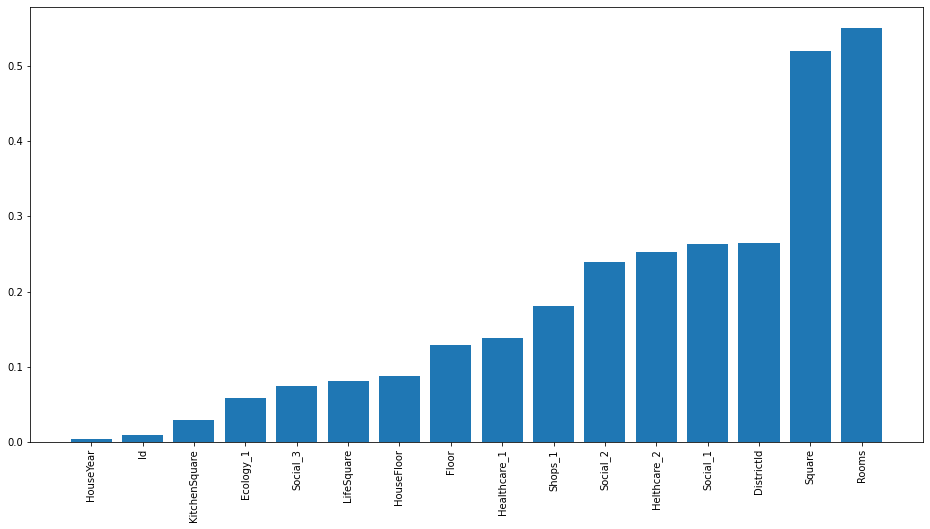

In [11]:
price_corr = ds.corr().abs()
price_corr = price_corr.unstack().sort_values()['Price']

plt.figure(figsize = (16, 8))
plt.bar(list(price_corr.keys())[:-1], list(price_corr)[:-1])
plt.xticks(rotation=90)
plt.show()

In [12]:
ds['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [13]:
ds.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [14]:
class Preprocessor:
    """
    Класс для предобработки датафрэима.
    """
    def __init__(self):
        """
        Конструктор.
        """
        self.current_year = datetime.datetime.now().year
        self.districts_rate = None
        self.medians = None
        self.districts_price_per_meter = None
        self.minmax = {
            'KitchenSquare': (),
            'HouseFloor': (),
            'Rooms': (),
            'LifeSquare': (),
            'Square': ()
        }
        self.house_floor_means = None
        self.districts_healthcare_1 = None
        self.healthcare_mean = None
        self.room_median_square = None  # средняя площадь комнаты
        self.pca = PCA(n_components=1, random_state=42)

    def fit(self, dataset: pd.DataFrame):
        """
        Расчет средних и медианных значений
        :param dataset:
        :return:
        """
        self.medians = dataset.groupby(['DistrictId']).agg(
            hf_median=('HouseFloor', np.median),
            lq_median=('LifeSquare', np.median),
            kq_median=('KitchenSquare', np.median),
            rooms_median=('Rooms', np.median)
        ).reset_index()
        self.house_floor_means = dataset.groupby('HouseYear').agg(
            hf_median=('HouseFloor', np.median),
            hf_min=('HouseFloor', np.min),
            hf_max=('HouseFloor', np.max)
        ).reset_index()

        self.districts_healthcare_1 = dataset.groupby(['DistrictId'])[
            'Healthcare_1'].agg('mean').to_dict()
        self.healthcare_mean = dataset['Healthcare_1'].mean()
        self.room_median_square = round(dataset['LifeSquare'].median()/dataset['Rooms'].median(),2)

        self.pca.fit(dataset[['Social_1','Social_2','Social_3']])

        self.districts_price_per_meter = (dataset.groupby(['DistrictId'])['Price'].agg('median') \
                                         / dataset.groupby(['DistrictId'])['Square'].agg('median')).to_dict()

        self.districts_rate = dict(dataset['DistrictId'].value_counts()/dataset.shape[0])
    def __fixes(self, dataset: pd.DataFrame) -> pd.DataFrame:
        """
        Фиксы датафрэима.
        :param dataset: Исходный датасет
        :return: pd.DataFrame
        """
        def fix_square(row):
            """
            Фикс общей площади
            :param row:
            :return: pd.Series
            """
            if row['Square'] < row['LifeSquare'] + row['KitchenSquare']:
                # Общая площадь не может быть меньше суммы площадей жилой и кухни
                row['Square'] = row['LifeSquare'] + row['KitchenSquare']
            return row

        def fix_house_year(row):
            """
            Фикс года постройки дома
            :param row:
            :return: pd.Series
            """
            house_year = row['HouseYear']
            try:
                house_year = datetime.datetime.strptime(str(int(house_year)), '%Y%d%m').year
            except ValueError:
                house_year = datetime.datetime.now().year

            row['HouseYear'] = house_year
            return row

        dataset = dataset.apply(fix_house_year, axis=1)
        dataset = dataset.apply(fix_square, axis=1)

        dataset.loc[(dataset['Rooms']==0)|(dataset['Rooms']>6),'Rooms'] = round(dataset.loc[
            (dataset['Rooms']==0)|(dataset['Rooms']>6),'LifeSquare']/self.room_median_square)
        dataset.loc[dataset['Rooms']==0,'Rooms'] = 1
        return dataset

    def __fillna(self, dataset: pd.DataFrame) -> pd.DataFrame:
        """
        Заполнение пропуской
        :param dataset: Исходный датафрэим
        :return: pd.DataFrame
        """
        def fill_house_floor(row):
            """
            Заполнение этажа
            :param row:
            :return: pd.Series
            """
            row['HouseFloor'] = float(
                self.house_floor_means.loc[self.house_floor_means['HouseYear'] == row['HouseYear']]['hf_median'])
            return row


        dataset.loc[dataset['Healthcare_1'].isna(), 'Healthcare_1'] = dataset['DistrictId'].map(self.districts_healthcare_1)
        # Те что не получилось заполнить по районам заполним средним значением
        dataset['Healthcare_1'].fillna(self.healthcare_mean, inplace=True)

        dataset.loc[dataset['HouseFloor'] < 2] = dataset.loc[dataset['HouseFloor'] < 2].apply(fill_house_floor, axis=1)
        # Вычислим соотношение остальной площади от общей площади
        other_koef = round((dataset['Square'] - dataset['KitchenSquare'] - dataset['LifeSquare']).median() / dataset['Square'].median(),3)
        # Заполнение пустой жилой площади
        dataset['LifeSquare'].fillna((dataset['Square']-dataset['KitchenSquare']-dataset['Square']*other_koef),inplace=True)
        # Заполнение пропусков комнат
        # dataset['Rooms'].fillna(self.medians[dataset['DistrictId']]['rooms_median'], inplace=True)
        # print(self.medians.loc(self.medians['DistrictId']==dataset['DistrictId'])['rooms_median'])
        return dataset

    def __new_featrures(self, dataset: pd.DataFrame) -> pd.DataFrame:
        """
        Добавление новых свойств.
        :param dataset:
        :return: ps.DataFrame
        """
        dataset['Social'] = self.pca.transform(dataset[['Social_1','Social_2','Social_3']])
        dataset['PPM'] = dataset['DistrictId'].map(self.districts_price_per_meter)
        dataset['District_rate'] = dataset['DistrictId'].map(self.districts_rate)

        dataset['PPM'].fillna(0, inplace=True)
        dataset['District_rate'].fillna(0, inplace=True)
        
        return dataset

    def transform(self, dataset: pd.DataFrame) -> pd.DataFrame:
        """
        Трансформирование датафрэима
        :param dataset:
        :return: pd.DataFrame
        """
        dataset = self.__fillna(dataset)
        dataset = self.__fixes(dataset)

        dataset.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        dataset.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        dataset.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

        dataset = self.__new_featrures(dataset)

        # удаляем лишние поля
        dataset = dataset.drop(['Social_1', 'Social_2', 'Social_3', 'Ecology_2', 'Ecology_3', 'Id'], axis=1)

        return dataset


In [15]:
prep = Preprocessor()
prep.fit(ds)
ds = prep.transform(ds)

In [16]:
TARGET = 'Price'
y_train = ds[TARGET]
X_train = ds.drop([TARGET], axis=1)

Опустим выбор лучших параметров для модели, а то выполнятся будет крайне долго
т.к. по условиям можно использовать только то что было на занятиях и максимально доступная модель это случайный лес, возьмём его

In [17]:
best_params = {'n_estimators': 700, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 13, 'bootstrap': False}

In [18]:
model = RandomForestRegressor(**best_params)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=13, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=12,
                      n_estimators=700)

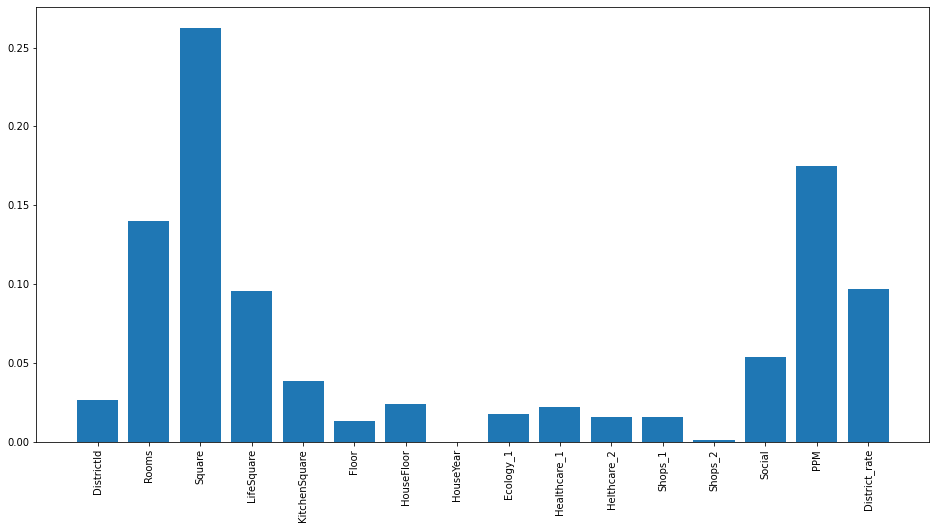

In [19]:
plt.figure(figsize = (16, 8))
plt.bar(list(X_train.keys()), list(model.feature_importances_))
plt.xticks(rotation=90)
plt.show()

### Прогнозирование цен на тестовом датасете

In [20]:
test_ds = pd.read_csv(TEST_PATH)
test_ds.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [21]:
# Загрузим сэмл
submit = pd.read_csv(SAMPLE_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [22]:
# Подготовим тестовые данные
test_ds = prep.transform(test_ds)
test_ds.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Social,PPM,District_rate
0,44,1.0,36.847630,19.094182,5.0,5,9.0,2022,0.036122,1036.00000,1,1,1,-974.155167,4431.704675,0.0104
1,62,1.0,52.568133,42.568133,10.0,7,17.0,2022,0.072158,2300.00000,0,0,0,-4723.213601,2859.977368,0.0247
2,27,2.0,59.463678,37.678987,9.0,19,19.0,2022,0.211401,1142.90446,0,1,1,-3460.195926,2669.535159,0.0851
3,23,3.0,49.646030,33.893825,6.0,2,2.0,2022,0.014073,0.00000,0,0,1,-4877.212675,2109.194622,0.0565
4,74,1.0,53.837056,41.262089,1.0,8,17.0,2022,0.309479,990.00000,0,6,1,2362.863079,3483.810063,0.0114


In [23]:
test_ds.isna().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Social           0
PPM              0
District_rate    0
dtype: int64

In [24]:
y_test = model.predict(test_ds)
y_test

array([160535.82226743, 127599.60636382, 145313.09791589, ...,
       147733.62052118, 189082.67438107, 266922.10971054])

In [25]:
submit['Price'] = y_test
submit.head()

,Id,Price
0,4567,160535.822267
1,5925,127599.606364
2,960,145313.097916
3,3848,120340.062310
4,746,179899.574948


In [26]:
# Сохраним результат
submit.to_csv('submission.csv', index=False)